In [1]:
import numpy as np
import ezbootstrap as ez
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")



DATA_DIR = Path(r"D:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")

def overlap_responders(x: np.ndarray, y: np.ndarray):
    return np.mean(y[x==1]) - np.mean(y)

def overlap_same(x: np.ndarray, y: np.ndarray):
    return np.mean(x == y)

def overlap_both(x: np.ndarray, y: np.ndarray):
    return np.mean((x + y) == 2)

def overlap_new(a, b):
    # prop of b's entries that are in a
    prop_b = np.mean(b[a == 1])

    # prop of a's entries that are in b
    prop_a = np.mean(a[b == 1])
    return np.min([prop_b, prop_a])

def boot(
    df1,
    df2,
    cell_col = "new_id",
    df1_p_col = "p",
    df2_p_col = "p",
    f = overlap_new,
    n_boot=1000
):
    df = pd.merge(
        df1[[cell_col, df1_p_col]].assign(sig1=lambda x: (x[df1_p_col] < 0.05).astype(int)).drop(df1_p_col, axis=1),
        df2[[cell_col, df2_p_col]].assign(sig2=lambda x: (x[df2_p_col] < 0.05).astype(int)).drop(df2_p_col, axis=1)
    )
    x = df["sig1"].values
    y = df["sig2"].values
    observed = f(x, y)
    reps = ez.bs_2sample(x, y, f, size=n_boot)
    return observed, reps

def get_p(obs, reps):
    return np.mean(reps >= obs)

def plot_boot(obs, reps):
    _, ax = plt.subplots()
    ax.hist(reps, color="black")
    ax.axvline(obs, color="red")
    return ax

def get_similarity_sig(df1, df2, f, n_boot=5000):
    obs, reps = boot(df1, df2, f=f, n_boot=n_boot)
    p = get_p(obs, reps)
    return obs, p

In [30]:
PERMS = {}

block_day2 = pd.read_csv(DATA_DIR / "day2-block-responders.csv")
freeze_day2_stops = pd.read_csv( DATA_DIR / "freeze_stops_day2.csv")
freeze_day2_starts = pd.read_csv( DATA_DIR / "freeze_starts_day2.csv")
block_day4 = pd.read_csv(DATA_DIR / "day4-block-responders.csv")
freeze_day4_starts = pd.read_csv( DATA_DIR / "freeze_starts_day4.csv")
freeze_day4_stops = pd.read_csv( DATA_DIR / "freeze_stops_day4.csv")

PERMS["freeze_day2_dem_starts"] = freeze_day2_starts[["new_id", "p_dem", "diff_of_medians_dem"]].rename(columns={"p_dem": "p", "diff_of_medians_dem": "diff_of_medians"})
PERMS["freeze_day2_dem_stops"] = freeze_day2_stops[["new_id", "p_dem", "diff_of_medians_dem"]].rename(columns={"p_dem": "p", "diff_of_medians_dem": "diff_of_medians"})
PERMS["block_day2_us"] = block_day2.loc[lambda x: x.block == "US"].copy()


PERMS["block_day2_cs"] = block_day2.loc[lambda x: x.block == "CS"].copy()[["new_id", "p", "diff_of_medians"]]
PERMS["freeze_day2_obs_starts"] = freeze_day2_starts[["new_id", "p_obs", "diff_of_medians_obs"]].rename(columns={"p_obs": "p", "diff_of_medians_obs": "diff_of_medians"})
PERMS["block_day2_us"] = block_day2.loc[lambda x: x.block == "US"].copy()[["new_id", "p", "diff_of_medians"]]
PERMS["freeze_day2_obs_stops"] = freeze_day2_stops[["new_id", "p_obs", "diff_of_medians_obs"]].rename(columns={"p_obs": "p", "diff_of_medians_obs": "diff_of_medians"})
PERMS["block_day2_us"] = block_day2.loc[lambda x: x.block == "US"].copy()
PERMS["freeze_day4_stops"] = freeze_day4_stops[["new_id", "p", "diff_of_medians"]]
PERMS["freeze_day4_starts"] = freeze_day4_starts[["new_id", "p", "diff_of_medians"]]
PERMS["block_day4_us"] = block_day4
idx = list(PERMS.keys())

In [76]:
data = []
for b1, df1 in PERMS.items():
    for b2, df2 in PERMS.items():
        overlap, p = get_similarity_sig(df1, df2, f=overlap_new, n_boot=1000)
        data.append([b1, b2, overlap, p])


C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\ezbootstrap\core.py:118: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")
C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\ezbootstrap\core.py:118: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")
C:\Users\roryl\.conda\envs\observational-fear\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\roryl\.conda\envs\observational-fear\lib\site-pa

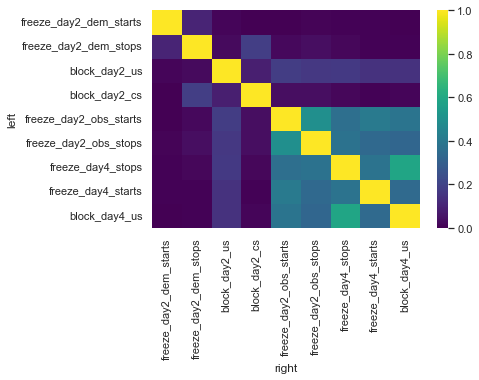

In [80]:
import seaborn as sns
df = pd.DataFrame(data, columns=["left", "right", "overlap", "p"])
dfp = df.pivot(index="left", columns="right", values="overlap").reindex(idx)[idx]
sns.heatmap(dfp, cmap="viridis")
plt.savefig("overlap heat.png", dpi=300)

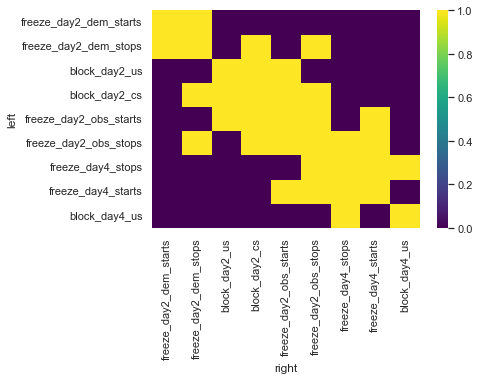

In [81]:
import seaborn as sns
df = pd.DataFrame(data, columns=["left", "right", "overlap", "p"])
dfp = df.pivot(index="left", columns="right", values="p").reindex(idx)[idx]
sns.heatmap(dfp < 0.05, cmap="viridis", )
plt.savefig("overlap pvals heat yellow means significant.png", dpi=300)

In [74]:
data = []
for b1, df1 in PERMS.items():
    for b2, df2 in PERMS.items():
        overlap, p = get_similarity_sig(df1, df2, f=overlap_both, n_boot=500)
        data.append([b1, b2, overlap, p])


<AxesSubplot:xlabel='right', ylabel='left'>

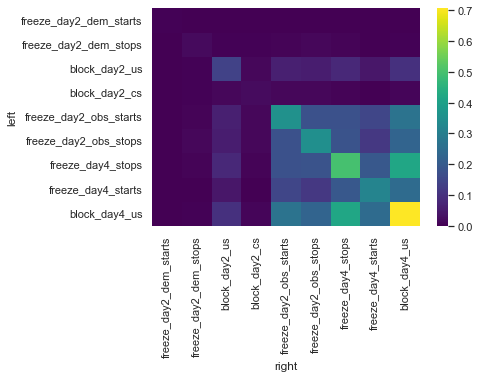

In [75]:
df = pd.DataFrame(data, columns=["left", "right", "overlap", "p"])
dfp = df.pivot(index="left", columns="right", values="overlap").reindex(idx)[idx]
sns.heatmap(dfp, cmap="viridis")

In [36]:

res = []
for name, df in PERMS.items():
    out = {}
    out["name"] = name
    out["num_responders"] = (df["p"] < 0.05).sum()
    out["total_neurons"] = len(df)
    out["num_activated"] = ((df["diff_of_medians"] > 0) & (df["p"] < 0.05)).sum()
    out["num_inhibited"] = ((df["diff_of_medians"] < 0) & (df["p"] < 0.05)).sum()
    res.append(out)


In [38]:
pd.DataFrame(res).to_csv("responders_res.csv", index=False)